# Third Home Assignment

Made by Group 3: <br>
- Diogo Araújo - fc60997 - 2H <br>
- João Braz - fc60419 - 2H <br>
- Joel Oliveira - fc59442 - 6H <br>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.cluster import KMeans, OPTICS, cluster_optics_dbscan
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.cluster import (silhouette_score, calinski_harabasz_score, 
                                     silhouette_samples, contingency_matrix, 
                                     homogeneity_score, completeness_score, 
                                     v_measure_score)
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.stats import gaussian_kde
from yellowbrick.cluster import KElbowVisualizer

In [2]:
def drawSillouette(X, labels, header="", ax=None, show_label=True, figsize=(10,4)):
    y_lower =10
    clusters=list(set(labels))
    n_clusters=len(clusters)
    if ax==None:
        fig, ax = plt.subplots(1,1, figsize=figsize)
    ax.set_xlim([-0.5, 1])
    ax.set_ylim([0, len(X) + (n_clusters) * 3+ y_lower])
    sil_avg = silhouette_score(X, labels)
    silhouette_values = silhouette_samples(X, labels)
    for i,c in enumerate(clusters):
        cs_values = silhouette_values[labels == c]
        cs_values.sort()
        size_ci = cs_values.shape[0]
        y_upper = y_lower + size_ci
        color = cm.nipy_spectral(i / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0,  cs_values, facecolor=color, 
                         edgecolor="k", alpha=0.7)
        if show_label:
            ax.text(-0.05, y_lower + 0.5 * size_ci, str(c))
        y_lower = y_upper + 3 
    ax.set_title("Silhouette plot "+ header)
    ax.set_xlabel("Silhouette coefficient")
    ax.set_ylabel("Clusters")
    ax.axvline(x=sil_avg, c="r", linestyle="--")
    ax.set_yticks([]) 

In [3]:
def plot_sillhouettes(X, model_labels, model_names):
    f, ax = plt.subplots(1,len(model_labels),figsize=(10,2))
    for i, (model, name) in  enumerate(zip(model_labels, model_names)):
        drawSillouette(X, model, name, ax=ax[i])

In [4]:
def plot_distance_density(data, dist_func, include_peaks=True, figsize=(6,3)):
    """
    Plots the density of the average distance of the points in the dataset
    """
    dists_avg = dist_func(data).mean(axis=1)
    v,c = np.unique(dists_avg, return_counts=True)
    kde = gaussian_kde(v, weights=c)
    density = kde(v)
    plt.figure(figsize=figsize)
    plt.plot(v, density)
    plt.xlabel("Average Distance")
    plt.ylabel("Density")

In [5]:
def plot_scores(x,y, xlabel="", ylabel="", title="", ax=None):
    if ax==None:
        f, ax = plt.subplots(1,1)
    ax.plot(x,y, "--*")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

In [6]:
def plot_reachability(space, reachibility, X, labels, threshold=None, figsize=(10,3)):
    if threshold==None:
        reach_filter = reachibility<np.inf
    else:
        reach_filter = reachibility<threshold
    filtered_labels = labels[reach_filter]
    filtered_space = space[reach_filter]
    filtered_reach = reachability[reach_filter]
    plt.figure(figsize=figsize)
    colors = ["r", "b", "y", "g", "orange", "c", "m", "purple", "olive", "aqua", "tomato"]
    plt.plot(filtered_space[filtered_labels==-1], filtered_reach[filtered_labels==-1], 
             "k.", alpha=0.2,)
    for k, color in zip(np.unique(labels), colors):
        if k!=-1:
            Xk = filtered_space[filtered_labels==k]
            Rk = filtered_reach[filtered_labels==k]
            plt.plot(Xk, Rk, ".", c=color, alpha=0.2)
    plt.ylabel("Reachability (epsilon distance)")
    plt.title("Reachability Plot")
    plt.grid()

In [7]:
def print_int_statistics(X, model_labels, model_names):
    for labels, name in zip(model_labels, model_names):
        print(name, f"| Silhouette = {silhouette_score(X, labels):.3f} | Calinski = \
{calinski_harabasz_score(X, labels):.3f} | Number of clusters = {len(np.unique(labels))}")

In [8]:
def kmeans_results(X, k_values, metric):
    _, ax = plt.subplots(1,1,figsize=(6,2))
    KElbowVisualizer(KMeans(n_init="auto", random_state=13),ax=ax, 
                     k=k_values, metric=metric ).fit(X).show();

# Intrinsic Evaluation

Firstly for each clustering method we will select the best parameters. Afterwards, we will make a final selection of which one seems to be the one with "better" clusters.

## Train dataset

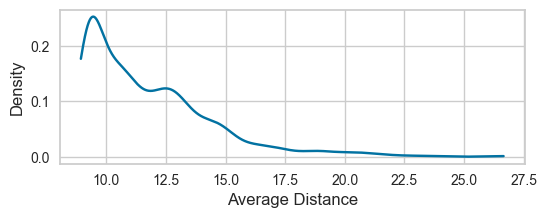

In [9]:
df_dense = pd.read_csv("train.csv").drop(columns="critical_temp")
df_dense = StandardScaler().set_output(transform="pandas").fit_transform(df_dense)
plot_distance_density(df_dense, euclidean_distances, figsize=(6,2))

### Hierarchical Clustering

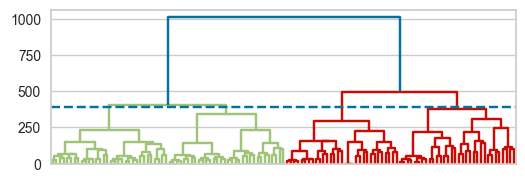

In [10]:
tree_results = linkage(df_dense, method="ward")
_, ax = plt.subplots(1,1, figsize=(6,2))
dendrogram(tree_results, truncate_mode="level", p = 6, no_labels=True, ax=ax );
ax.hlines(390, 0, 20000, linestyles="--");

In [11]:
ward_labels=cut_tree(tree_results, height=390).ravel()

### KMeans

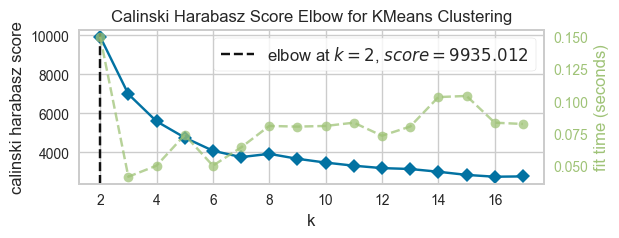

In [12]:
kmeans_results(df_dense, range(2,18), "calinski_harabasz")

In [13]:
kmeans = KMeans(n_clusters=2, n_init="auto", random_state=13).fit(df_dense)

### DBSCAN

In [14]:
opts_dense = OPTICS(min_cluster_size=0.05, min_samples=0.01, n_jobs=-1).fit(df_dense)
space = np.arange(len(df_dense))
reachability = opts_dense.reachability_[opts_dense.ordering_]
labels = opts_dense.labels_[opts_dense.ordering_]

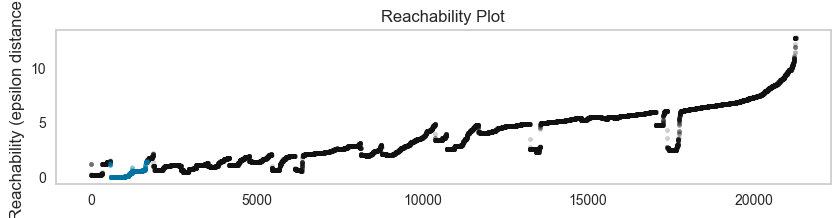

In [15]:
plot_reachability( space, reachability, df_dense, labels, figsize=(10,2))

In [16]:
dbs_labels = cluster_optics_dbscan(
    reachability=opts_dense.reachability_, core_distances=opts_dense.core_distances_,
    ordering=opts_dense.ordering_, eps=3)

### Compare Results

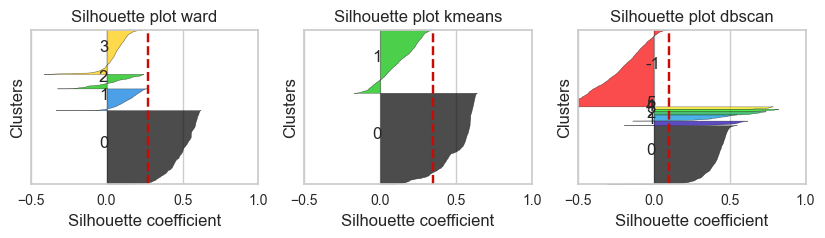

In [18]:
plot_sillhouettes(df_dense, [ward_labels, kmeans.labels_, dbs_labels], ["ward", "kmeans", "dbscan"])

In [19]:
print_int_statistics( df_dense, [ward_labels, kmeans.labels_, dbs_labels], ["ward", "kmeans", "dbscan"])

ward | Silhouette = 0.273 | Calinski = 5114.066 | Number of clusters = 4
kmeans | Silhouette = 0.347 | Calinski = 9935.012 | Number of clusters = 2
dbscan | Silhouette = 0.102 | Calinski = 1685.674 | Number of clusters = 7


From analyzing the previous clusters, and comparing them by using silhouette, we chose *KMeans* as our clustering method for the `train.csv` dataset. When compared with the other methods, Kmeans finds two big clusters. These results made more sense when compared with the other approaches, to which DBSCAN found a few small clusters and HAC found clusters of varying sizes but with a few silhouette scores. 

## Unique Dataset

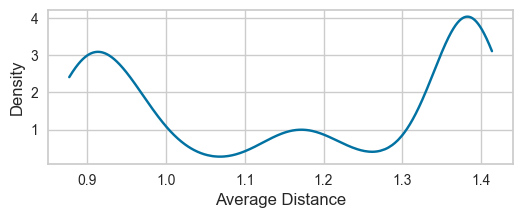

In [20]:
df_sparse = pd.read_csv("unique_m.csv").drop(columns=["material", "critical_temp"])
constant_cols = df_sparse.columns[df_sparse.std()==0]
df_sparse = df_sparse.drop(columns=constant_cols)
df_sparse = Normalizer().set_output(transform="pandas").fit_transform(df_sparse)
plot_distance_density(df_sparse, euclidean_distances, figsize=(6,2))

### Hierarchical Clustering

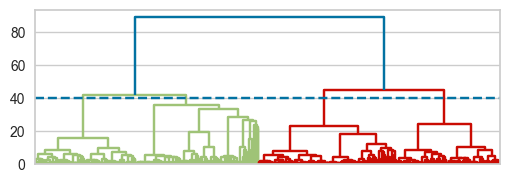

In [21]:
tree_results = linkage(df_sparse, method="ward")
_, ax = plt.subplots(1,1, figsize=(6,2))
dendrogram(tree_results, truncate_mode="level", p=10, no_labels=True, ax=ax);
ax.hlines(40,0, 20000, linestyle="--");

In [22]:
ward_labels = cut_tree(tree_results, height=40).ravel()

### Kmeans

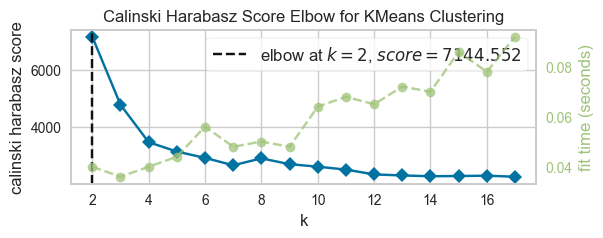

In [23]:
kmeans_results(df_sparse, range(2,18), "calinski_harabasz")

In [24]:
kmeans=KMeans(n_clusters=2, n_init="auto", random_state=13).fit(df_sparse)

### DBSCAN

In [25]:
opts_sparse = OPTICS(min_cluster_size=0.05, min_samples=0.02, n_jobs=-1).fit(df_sparse)
space = np.arange(len(df_sparse))
reachability = opts_sparse.reachability_[opts_sparse.ordering_]
labels = opts_sparse.labels_[opts_sparse.ordering_]

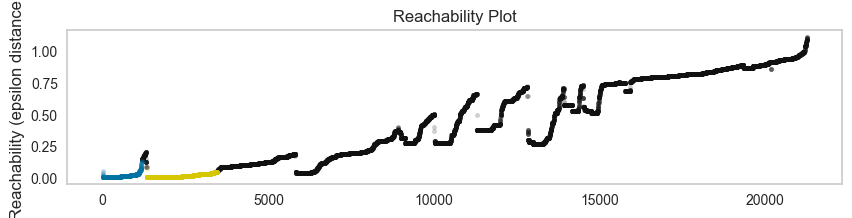

In [26]:
plot_reachability( space, reachability, df_sparse, labels, figsize=(10,2))

In [27]:
dbs_labels = cluster_optics_dbscan(
    reachability=opts_sparse.reachability_, core_distances=opts_sparse.core_distances_,
    ordering=opts_sparse.ordering_, eps=.5)

### Compare Results

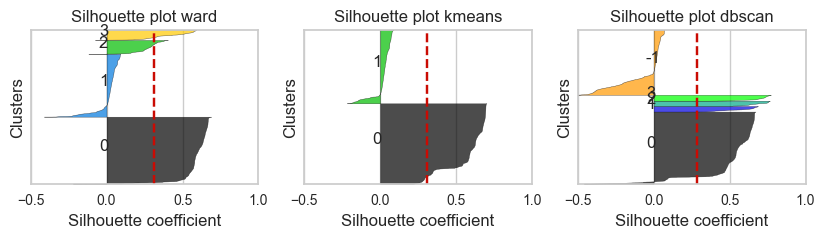

In [28]:
plot_sillhouettes(df_sparse, [ward_labels, kmeans.labels_, dbs_labels], ["ward", "kmeans", "dbscan"])

In [29]:
print_int_statistics(df_sparse,[ward_labels, kmeans.labels_, dbs_labels],["ward", "kmeans", "dbscan"])

ward | Silhouette = 0.314 | Calinski = 4054.139 | Number of clusters = 4
kmeans | Silhouette = 0.309 | Calinski = 7144.552 | Number of clusters = 2
dbscan | Silhouette = 0.286 | Calinski = 2928.424 | Number of clusters = 5


From analyzing the previous clusters, and comparing them by using silhouette, we chose HAC with ward linkage as our clustering method for the train dataset. When compared with the other methods, it found four clusters of varying sizes and coefficients. K-Means a big cluster and a small one with negative scored samples, and DBScan found a large cluster with a few smaller clusters surrounding it. 

# Extrinsic Evaluation
We will evaluate the models selected based on the *intrisic evaluation* and see how they perform using *extrinsic evaluation*. We will also see how the **true labels** perform with the *intrinsic methods*. Finally we will also compare the results with the **random assignement** of a label.

In [30]:
def to_class(x):
    if 0<=x<1:
        return "0 - Very Low"
    if x<5:
        return "1 - Low"
    if x<20:
        return "2 - Medium"
    if x<100:
        return "3 - High"
    return "4 - Very High"

In [31]:
def contengency_matrix(y, labels):
    return pd.DataFrame(
        data=contingency_matrix(y, labels),
        columns=np.unique(labels),
        index=np.unique(y))

In [32]:
def print_ext_statistics(y, labels):
    print(f"Homogeneity = {homogeneity_score(y, labels):.3f} | Completeness = \
{completeness_score(y, labels):.3f} | V-Measure = {v_measure_score(y, labels):.3f}")

In [33]:
y = pd.read_csv("train.csv")["critical_temp"].apply(to_class)

In [34]:
print_int_statistics(df_sparse, [y], ["ground truth"])
print_int_statistics(df_dense, [y], ["ground truth"])

ground truth | Silhouette = 0.002 | Calinski = 1019.975 | Number of clusters = 5
ground truth | Silhouette = -0.002 | Calinski = 1615.781 | Number of clusters = 5


For both the *sparse and* the *dense* datasets silhouette scores obtained with the *true labels* are not good. This could mean that the classes are not well clustered in space and/or the transformations performed on the data were not the most suitable. 

In [35]:
dense_labels =  KMeans(n_clusters=2, n_init="auto", random_state=13).fit_predict(df_dense)
sparse_labels = cut_tree(linkage(df_sparse, method="ward"), height=40).ravel()
random_labels = np.random.randint(y.nunique(), size=len(y))

In [36]:
print_ext_statistics(y, dense_labels)
print_ext_statistics(y, sparse_labels)
print_ext_statistics(y, random_labels)

Homogeneity = 0.222 | Completeness = 0.424 | V-Measure = 0.292
Homogeneity = 0.278 | Completeness = 0.319 | V-Measure = 0.297
Homogeneity = 0.000 | Completeness = 0.000 | V-Measure = 0.000


We can see that random assignment has way worse results than the labeling created by the clusters. This means that although the model was not created with any information about the real classes it could capture some meaning from the data.

In [37]:
contengency_matrix(y, dense_labels)

,0,1
0 - Very Low,83,918
1 - Low,591,3427
2 - Medium,1972,3596
3 - High,9109,765
4 - Very High,800,2


From the contengency matrix above, we can see that the cluster $0$ contains most of the data with *high values* (*High*, *Very High*). The other cluster has most of the data with **lower values**(*Very Low*, *Low*, *Medium*).

In [38]:
contengency_matrix(y, sparse_labels)

,0,1,2,3
0 - Very Low,81,864,49,7
1 - Low,279,3591,24,124
2 - Medium,1213,3673,90,592
3 - High,7210,549,1427,688
4 - Very High,473,1,328,0


In the contengency matrix built from the clusters of the sparse matrix we can see a patterns similar to the clusters built from the dense data. The clusters $0$ and $2$ have data with higher `critical_temp` values, while cluster $3$ contains some *Medium* and *Higher* elements that may be away from cluster $0$. The cluster $1$ is centered around the lower values.